In [1]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from rouge_score import rouge_scorer
from sklearn.metrics.pairwise import cosine_similarity
import os

class ETfidf():
    def __init__(self):
        self.vectorizer = TfidfVectorizer(stop_words='english')

    def preprocess_sentence(self, sentence):
        """Preprocess the sentence by removing empty strings and stop words."""
        if sentence == "":
            return ''  # Return empty string for empty input
        return sentence.lower().strip()

    def calculate_inner_sentence_diversity(self, sentence):
        """
        Calculate inner-sentence diversity using TF-IDF cosine similarity.
        This measures how diverse the words in a sentence are.
        """
        # Preprocess the sentence to ensure no empty strings
        words = sentence.split()  # Split into words (you can adjust the tokenizer)
        
        if len(words) < 2:
            return 0.0  # Too few words to calculate diversity

        # Calculate TF-IDF vectors for the words in the sentence
        try:
            tfidf_matrix = self.vectorizer.fit_transform(words)
        except:
            return 0.0
        
        # Compute cosine similarities between each pair of words
        cosine_similarities = cosine_similarity(tfidf_matrix)

        # We want to consider only the upper triangular part (pairs of words)
        total_similarity = 0.0
        count = 0

        for i in range(len(words)):
            for j in range(i + 1, len(words)):
                total_similarity += cosine_similarities[i, j]
                count += 1

        return 1 - (total_similarity / count) if count > 0 else 0.0  # Return the "diversity" as the inverse of similarity

    def calculate_inter_sentence_diversity(self, sentences):
        """
        Calculate inter-sentence diversity using TF-IDF cosine similarity.
        This measures how diverse the sentences are compared to each other.
        """
        if len(sentences) < 2:
            return 0.0  # Too few sentences to calculate inter-sentence diversity

        # Calculate TF-IDF vectors for each sentence
        try:
            tfidf_matrix = self.vectorizer.fit_transform(sentences)
        except:
            return 0.0

        # Compute cosine similarities between each pair of sentences
        cosine_similarities = cosine_similarity(tfidf_matrix)

        # We want to consider only the upper triangular part (pairs of sentences)
        total_similarity = 0.0
        count = 0

        for i in range(len(sentences)):
            for j in range(i + 1, len(sentences)):
                total_similarity += cosine_similarities[i, j]
                count += 1

        return 1 - (total_similarity / count) if count > 0 else 0.0  # Return the "diversity" as the inverse of similarity

    def calculate_diversities(self, answers):
        """
        Calculate diversity scores (inner and inter sentence diversity) for answers.
        """
        inner_diversities = []
        inter_diversities = []
        
        for answer_set in answers:
            answer_set = [self.preprocess_sentence(answer) for answer in answer_set]
            answer_set = [answer for answer in answer_set if answer]
            if not answer_set:
                continue
            inner_diversity_scores = [self.calculate_inner_sentence_diversity(answer) for answer in answer_set]
            inner_diversity_mean = np.mean(inner_diversity_scores) if inner_diversity_scores else 0.0
            inner_diversities.append(inner_diversity_mean)
            
            inter_diversity = self.calculate_inter_sentence_diversity(answer_set)
            inter_diversities.append(inter_diversity)
        
        inner_diversity_mean = np.mean(inner_diversities)
        inter_diversity_mean = np.mean(inter_diversities)
        
        return inner_diversity_mean, inter_diversity_mean

    def cal_scores(self, cans):
        # Create separate lists for each score type
        inner_diversity_list = []
        inter_diversity_list = []

        for can_list in cans:            
            # Calculate diversity scores
            inner_diversity, inter_diversity = self.calculate_diversities(can_list)

            # Append the results to the corresponding lists
            inner_diversity_list.append(inner_diversity)
            inter_diversity_list.append(inter_diversity)

        # Return the lists of scores
        return inner_diversity_list, inter_diversity_list


In [2]:
answers = [[
    ["The cat is on the mat.", "A cat lies on a mat.", "The cat rests on the rug."],
    ["I enjoy hiking in the mountains.", "Hiking is a great activity.", "Mountains are perfect for hiking."],
    ["The car is fast.", "It is a fast car.", "The vehicle is quick."],
    ["", "", ""],
    ["I love playing football.", "Football is fun.", "Soccer is a great sport."]
]]

references = [
    ["The cat is resting on the mat.", "A cat is lying on a mat.", "The cat is relaxing on the rug."],
    ["I love hiking in the mountains.", "Hiking is one of my favorite activities.", "Mountains are great for hiking."],
    ["The car moves quickly.", "It is a very fast car.", "The vehicle moves at high speed."],
    ["", "", ""],
    ["I enjoy playing football.", "Football is very exciting.", "Soccer is a popular sport."]
]


In [3]:
e = ETfidf()
e.cal_scores(answers)

([1.0], [0.7341927835889863])

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [5]:
projects = ["threshold"]
project_names = {"top-k": "Top-k Retrieval", "threshold": "Similarity Threshold Retrieval"}
datasets = ["NQ", "TriviaQA"]
vary_terms = {"top-k": "k", "threshold": "th"}
vary_values = {("top-k", "k"): [0, 1, 2, 3, 5, 10, 15, 20, 30, 40], ("threshold", "th"): [0, 0.3, 0.5, 0.6, 0.7, 0.75, 0.8, 0.83, 0.85, 0.88, 0.9, 0.92, 0.95, 0.98, 1]}
metrics = ["Inner Diversity", "Inter Diversity"]


In [6]:
eval = ETfidf()

In [7]:
scores = {}

for project in projects:
    term = vary_terms[project]
    values = vary_values[(project, term)]
    scores[project] = {}
    for metric in metrics:
        scores[project][metric] = []

    for ds in datasets:
        folder_path = f"clean_data/{project}/{ds}"
        canlist_path = folder_path+"/cans_list.json"
        ref_path = folder_path+"/refs.json"
        
        with open(canlist_path, "r") as f:
            cans_list = json.load(f)
        with open(ref_path, "r") as f:
            refs = json.load(f)
        scores_ = eval.cal_scores(cans_list)

        for i in range(2):
            metric = metrics[i]
            score_ = scores_[i]
            for j in range(len(values)):
                term_value = values[j]
                scores[project][metric].append({f'{term}': term_value, f'{metric} Score': score_[j], "dataset": ds})
        
        

In [9]:
import os

os.makedirs("tf-idf", exist_ok=True)

with open("tf-idf/evaluation_results.json", "a") as f:
    json.dump(scores, f, indent=4)

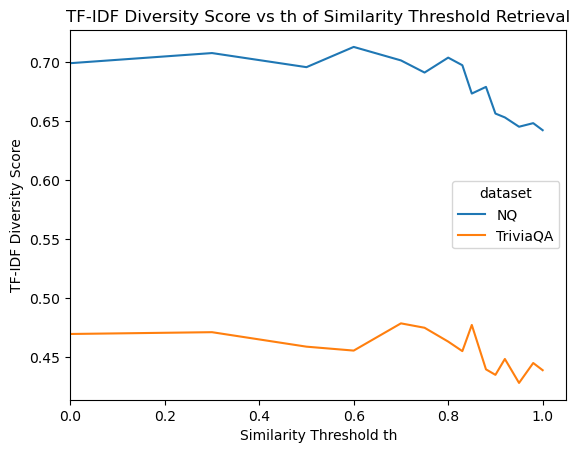

In [15]:
for project in ["threshold"]:
    term = vary_terms[project]
    name = project_names[project]
    for metric in ["Inter Diversity"]:
        score_data = pd.DataFrame(scores[project][metric])
        sns.lineplot(x=f'{term}', y=f'{metric} Score', data=score_data, hue="dataset")
        plt.xlim(0,)
        plt.xlabel("Similarity Threshold th")
        plt.ylabel("TF-IDF Diversity Score")
        plt.title(f'TF-IDF Diversity Score vs {term} of Similarity Threshold Retrieval')
        plt.savefig(f'tf-idf/{project}_{metric}.png')
        plt.show()

In [16]:
for ds in datasets:
    print(ds)
    print(score_data[score_data["dataset"]==ds]["Inter Diversity Score"].values)
    print('\n')

NQ
[0.69916812 0.70774625 0.69579931 0.71294863 0.70151655 0.69123096
 0.70388081 0.6974208  0.67342191 0.67907929 0.6564765  0.6532082
 0.6453102  0.64834758 0.64237602]


TriviaQA
[0.46967562 0.47120097 0.4589243  0.4556042  0.47867965 0.47494627
 0.46322599 0.45513801 0.4773248  0.4397033  0.43503927 0.4485053
 0.42820148 0.44508024 0.43898438]




In [14]:
score_data = pd.DataFrame(scores["threshold"]["Inter Diversity"])

for ds in datasets:
    print("TF-IDF diversity of "+ds)
    print(score_data[score_data["dataset"]==ds])
    print('\n')

TF-IDF diversity of NQ
      th  Inter Diversity Score dataset
0   0.00               0.699168      NQ
1   0.30               0.707746      NQ
2   0.50               0.695799      NQ
3   0.60               0.712949      NQ
4   0.70               0.701517      NQ
5   0.75               0.691231      NQ
6   0.80               0.703881      NQ
7   0.83               0.697421      NQ
8   0.85               0.673422      NQ
9   0.88               0.679079      NQ
10  0.90               0.656476      NQ
11  0.92               0.653208      NQ
12  0.95               0.645310      NQ
13  0.98               0.648348      NQ
14  1.00               0.642376      NQ


TF-IDF diversity of TriviaQA
      th  Inter Diversity Score   dataset
15  0.00               0.469676  TriviaQA
16  0.30               0.471201  TriviaQA
17  0.50               0.458924  TriviaQA
18  0.60               0.455604  TriviaQA
19  0.70               0.478680  TriviaQA
20  0.75               0.474946  TriviaQA
21  0.80    